## Chapter 4 from Bjornstad (2018): Force of infection and age-dependent incidence

Let us assume we test some $n_a$ individuals of each age $a$ and find from serology that $i_a$ individuals have been previously infected. Inferring $\phi$ from this data is a standard(ish) binomial regression problem: $p(a)=1-exp(- \phi a)$ is the expected fraction infected (or seropositive) by age $a$. Thus $\log(-\log(1-p(a)))=\log(\phi)+\log(a)$, so we can estimate a constant log-FoI as the intercept from a `glm` with binomial error, a complimentary log-log link and log-age as a regression ‘offset. We can illustrate the approach using the pre-vaccination Measles antibody data. The data contain seroprevalence-by-age-bracket of some 300 people from around New Haven, Connecticut from blood drawn in the summer of 1957:

In [1]:
library(epimdr)
data(black)
black

Loading required package: shiny
Loading required package: deSolve
Loading required package: phaseR
Loading required package: polspline


age,mid,n,pos,neg,f
<1,0.75,10,8,2,0.8000000
1-4,2.50,21,4,17,0.1904762
5-9,7.00,41,31,10,0.7560976
10-14,12.00,52,50,2,0.9615385
15-19,17.00,30,28,2,0.9333333
20-29,25.00,38,37,1,0.9736842
30-39,35.00,51,49,2,0.9607843
40-49,45.00,35,31,4,0.8857143
>50,60.00,30,26,4,0.8666667


The age-profile of seroprevalence takes the characteristic shape of many pre-vaccination childhood diseases: High seroprevalence of the very young (&lt; 1 yr) due to the presence of maternal antibodies that wanes with age, followed by rapid build-up of immunity to almost 100% seroprevalence by age 20 (fig \[fig:black\]). There is perhaps some evidence of loss of immunity in the elderly. We use the binomial regression scheme to estimate the log-FoI based on the data for people in the 1-40 yr groups, and compare predicted and observed seroprevalence by age (\[fig:black\]):

(Intercept) 
  0.1653329

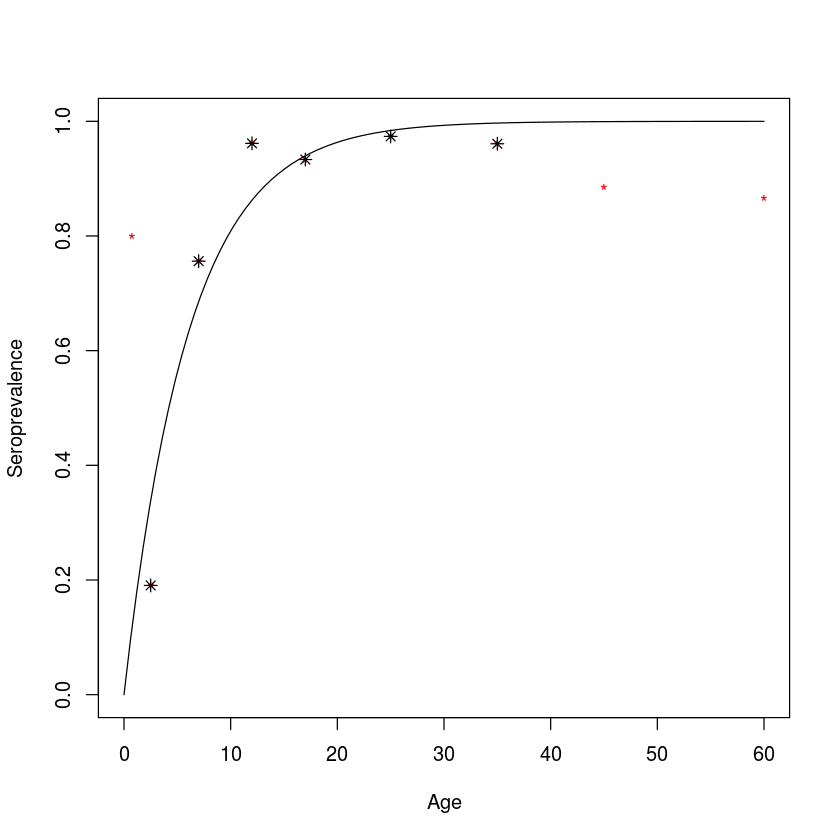

In [2]:
b2 = black[-c(1,8,9),]  #subsetting age brackets
#Estimate log-FoI
fit = glm(cbind(pos,neg) ~ offset(log(mid)), 
    family = binomial(link = "cloglog"), data = b2)
#Plot predicted and observed
phi = exp(coef(fit))
curve(1-exp(-phi*x), from = 0, to = 60, 
     ylab = "Seroprevalence", xlab = "Age")
points(black$mid, black$f, pch = "*", col = "red")
points(x = b2$mid, y = b2$f, pch = 8)
exp(fit$coef)

The estimated FoI is 0.16/year, giving a predicted mean age of infection of 6 years.

More flexible $\phi$-functions
------------------------------

The assumption of a constant, age-invariant FoI is usually too simplistic because of age- or time-varying patterns of mixing. We can use data on prevalence of the bacterium *Bordetella bronchiseptica* in a rabbit breeding facility to illustrate. *B. bronchiseptica* is a non-immunizing, largely avirulent (though it can cause snuffles), persistent infection of rabbits. Two-hundred and fourteen rabbits of known age were swabbed nasally and tested for the bacterium.

In [3]:
data(rabbit)
head(rabbit)

a,n,inf
1.0,59,3
2.0,8,7
2.5,4,4
3.0,2,1
3.5,5,1
4.0,2,0


We first calculate the average FoI from the binomial regression scheme introduced above. In the breeding facility the older breeding animals are kept separate from the younger animals, so we restrict ourselves to rabbits $<1$ years old. We superimpose our fit on the plot of prevalence by age. In figure \[fig:rabbit\] the size of the circles is proportional to the sample size:

(Intercept) 
   5.918273

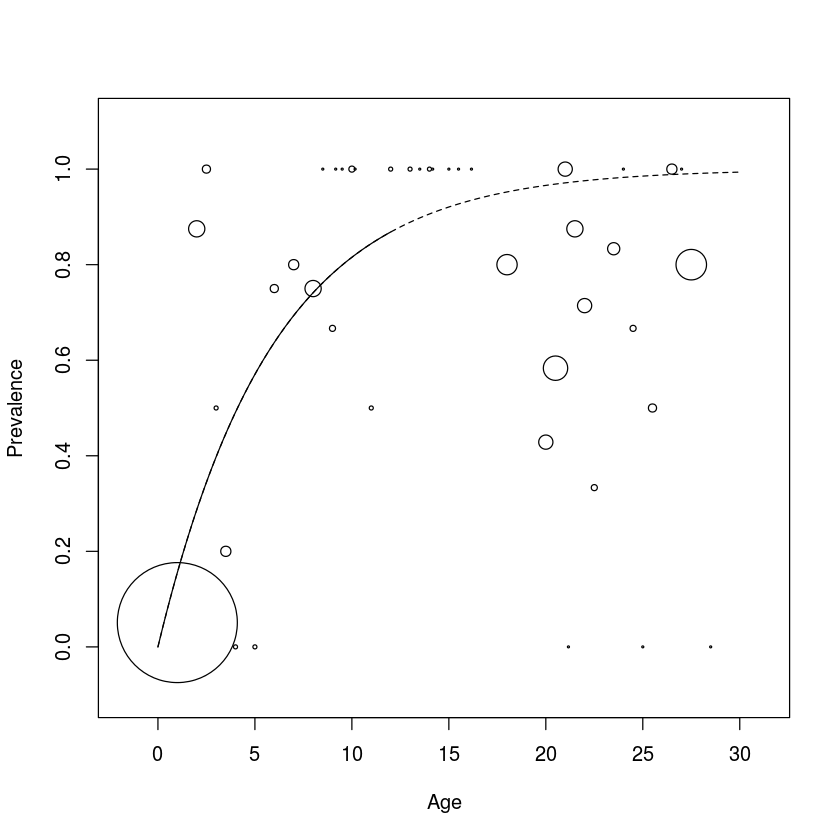

In [4]:
rabbit$notinf = rabbit$n - rabbit$inf
#Binomial regression
fit = glm(cbind(inf, notinf) ~ offset(log(a)), 
    family = binomial(link = "cloglog"),
    data = rabbit, subset = a<12)
#Plot data
symbols(rabbit$inf/rabbit$n ~ rabbit$a, circles = rabbit$n, 
     inches = 0.5, xlab = "Age", ylab = "Prevalence")
#Predicted curves for <1 and all 
phi = exp(coef(fit))
curve(1-exp(-phi*x), from = 0, to = 12, add = TRUE)
curve(1-exp(-phi*x), from = 0, to = 30, add = TRUE, lty = 2)
1/phi

The predicted median age of infection is just under 6 months. The constant-FoI model seem to do well for up to about 15 months of age, but the model over-predicts the prevalence in older individuals. To allow for the scenario that the FoI varies with age, we need to implement our own framework (as opposed to using `glm`) using the maximum likelihood ideas introduced in section \[sec:c2cb\]. A simple model for age-specific FoI assumes a piecewise constant model , where individuals are classified into discrete age classes. For a piecewise constant model the integrand in equation \[eq:p\] integrates to $\phi_a (a-c_a)+ \sum_{k<a} \phi_k d_k$, where $\phi_a$ is the FoI of individuals in the $a$’th age bracket, and $c_a$ and $d_a$ are the lower cut-off age and duration of that bracket, respectively. We define a function for the integrand which takes the argument `a` for age, `up` is a vector of the upper cut-offs for each age bracket, and `foi` is the vector of age-specific FoI’s:

In [5]:
integrandpc = function(a, up, foi){
  #Find which interval a belongs to
  wh = findInterval(a, sort(c(0,up)))
  #Calculate duration of each interval
  dur = diff(sort(c(0,up)))
  #Evaluate integrand
  inte = ifelse(wh == 1, foi[1]*a, 
       sum(foi[1:(wh-1)]*dur[1:(wh-1)])+
          foi[wh]*(a-up[wh-1]))
  return(inte)
}

The negative log-likelihood function for the piecewise constant model takes arguments corresponding to log-FoI (`par`), age (`age`), number of positives (`num`), number tested in each age group (`denom`) and age-class cut-offs (`up`). Estimating the FoI on a log-scale `(foi=exp(par))` ensures that all rates will be positive.

In [6]:
llik.pc = function(par, age, num, denom, up) {
    ll = 0
    for (i in 1:length(age)) {
       p = 1 - exp(-integrandpc(a=age[i], up = up, 
          foi = exp(par)))
       ll = ll + dbinom(num[i], denom[i], p, log = T)
    }
return(-ll)
}

We use 1, 4, 8, 12, 18, 24 and 30 months as cut-off points for the age-categories and assign arbitrary initial values of 0.1 for each piece of the FoI-function:

In [7]:
x = c(1, 4, 8, 12, 18, 24, 30)
para = rep(0.1, length(x))

For his analysis we use the `optim`-function (we could also use `mle2`) to find maximum likelihood estimates:

In [8]:
est = optim(par=log(para),fn=llik.pc, age=rabbit$a, 
     num=rabbit$inf,  denom=rabbit$n, up=x, 
     method="Nelder-Mead", control=list(trace=2))

  Nelder-Mead direct search function minimizer
function value for initial parameters = 70.627091
  Scaled convergence tolerance is 1.05243e-06
Stepsize computed as 0.230259
BUILD              8 73.376577 69.992539
EXTENSION         10 72.524831 68.209065
LO-REDUCTION      12 72.039597 68.209065
EXTENSION         14 71.252242 66.723042
LO-REDUCTION      16 71.023193 66.723042
LO-REDUCTION      18 70.627091 66.723042
EXTENSION         20 70.500600 65.488893
EXTENSION         22 69.992539 63.525916
LO-REDUCTION      24 68.616649 63.525916
LO-REDUCTION      26 68.209065 63.525916
REFLECTION        28 67.443654 63.293935
LO-REDUCTION      30 66.736993 63.293935
LO-REDUCTION      32 66.723042 63.293935
LO-REDUCTION      34 65.488893 63.293935
EXTENSION         36 64.279298 61.584960
LO-REDUCTION      38 64.093291 61.584960
LO-REDUCTION      40 63.954153 61.584960
LO-REDUCTION      42 63.547868 61.584960
EXTENSION         44 63.536244 60.916671
LO-REDUCTION      46 63.525916 60.916671
LO-REDU

The maximum likelihood estimates for the log-FoI is given in `est$par`. The associated age-specific FoIs are:

In [9]:
round(exp(est$par), 4)

[1] 0.0626 0.3712 0.0573 0.0000 0.0000 0.0000 0.0027

We can predict the age-prevalence curve and plot it as a step function.

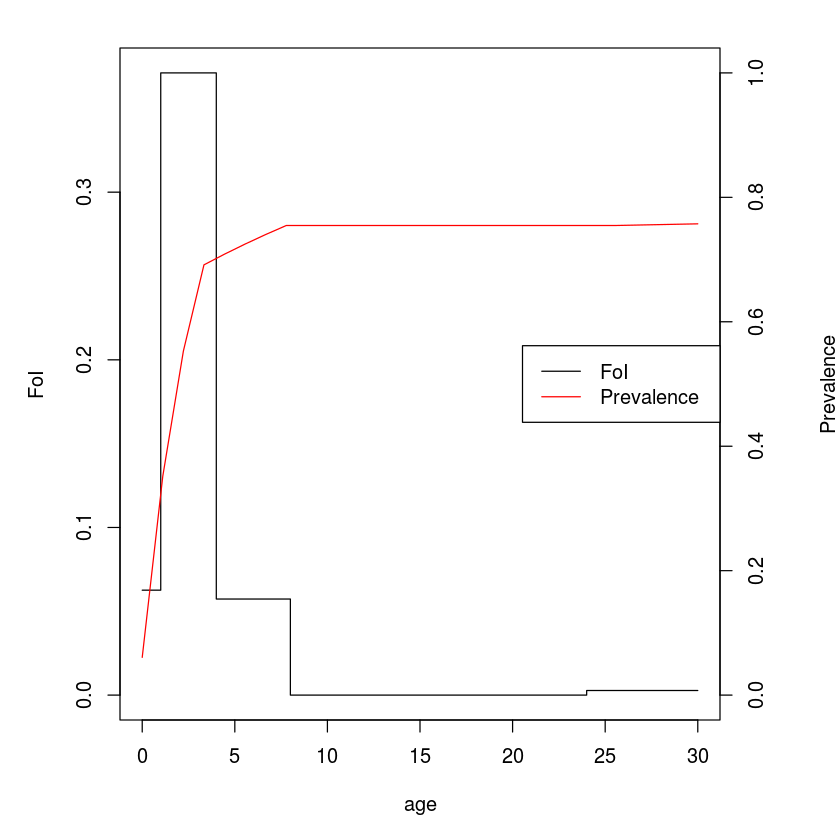

In [10]:
#Make space for left and right axes
par(mar = c(5,5,2,5))
#Add beginning and ends to x and y for step plot
xvals=c(0,x)
yvals=exp(c(est$par, est$par[7]))
plot(xvals, yvals, type="s", xlab="age", ylab="FoI")

#Superimpose predicted curve
par(new=T)
p = rep(0, 28)
for (i in 1:28) {
     p[i] = 1 - exp(-integrandpc(a=i, up = x, 
        foi = exp(est$par)))
}
plot(p~c(1:28), ylim=c(0,1), type="l", col="red", 
     axes=FALSE, xlab=NA, ylab=NA)

#Add right axis and legend
axis(side = 4)
mtext(side = 4, line = 4, "Prevalence")
legend("right", legend=c("FoI", "Prevalence"),
     lty=c(1,1), col=c("black", "red"))

The FoI peaks perinatally and then falls to zero after the 8 month age class. This is likely due to the older breeder females being housed separately and only having contact with their kittens. used this (in combination with some other analyses; see section \[sec:c13bb\]) to conclude that most infections happen at a young age from infected mothers to their offspring and then among litter mates.

A log-spline model
------------------

An alternative non-parametric approach to the piecewise constant model is to use smoothing splines. A [](https://en.wikipedia.org/wiki/Smoothing_spline) is a smooth curve that can take an arbitrary shape except that it is constrained to be continuous and with continuous 1st and 2nd derivatives . The popularity of splines in non-parametric regression stems from its computational tractability; A spline can be fit by multiple regression on a set of ‘basis function’-decompositions of a covariate. The `gam` and `mgcv` packages offers automated ways to fit a variety of spline-variants to binomial data (and any other error distribution within the exponential family). Unfortunately, as with the case of the piecewise constant model, fitting the log-spline model is a bit more involved because of the integration step in equation \[eq:p\]. The `splines` package has functions to create various spline-bases that can be used with `lm`; `predict.lm` can predict values for the spline given regression coefficients.

The approach taken here is a bit cheeky in that it ‘hi-jacks’ a spline-regression object created using the `bs`-spline basis functions in combination with `lm` and use `optim` to update/override the regression coefficients in the `lm`-object until a maximum likelihood solution is found. First we set the number of degrees-of-freedom for the spline. The `dl`-object will end up as the hi-jacked object for the age-specific FoI .

In [11]:
require(splines)
# Degrees-of-freedom
df = 7
# Construct dummy lm-object
dl = lm(inf ~ bs(a, df), data = rabbit)

Loading required package: splines


We write a `tmpfn`-function to predict the spline on a log-transformed scale to ensure that the force-of-infection (FoI) is strictly positive:

In [12]:
tmpfn = function(x, dl) {
    x = predict(dl, newdata = data.frame(a = x))
    exp(x)
}

The `tmpfn2`-function calculates the negative log-likelihood of the FoI as we did in the `foipc`-function above. In contrast to the piecewise constant model, the integrated splines do not have a closed form solution so we use Rs inbuilt numerical integrator, `integrate`:

In [13]:
tmpfn2 = function(par, data, df){
   #Dummy lm-object
   dl = lm(inf ~ bs(a,df), data = data)
   #Overwrite spline coefficients with new values
   dl$coefficients = par
   #Calculate log-likelihood 
   ll = 0
   for(i in 1:length(data$a)){
     p = 1 - exp(-integrate(tmpfn, 0, i, dl = dl)$value)
     ll = ll + dbinom(data$inf[i], data$n[i], p ,log = T)
   }
 return(-ll)
 }

We use arbitrary initial values and minimize the negative log-likelihood using `optim`. (Warnings are turned off to avoid excessive output)

In [14]:
options(warn=-1)
para = rep(-1, df + 1)
dspline = optim(par = para, fn = tmpfn2, data = rabbit, 
     df = df, method = "Nelder-Mead", control =
     list(trace = 2, maxit = 2000))
options(warn=0)

  Nelder-Mead direct search function minimizer
function value for initial parameters = 143.107967
  Scaled convergence tolerance is 2.13247e-06
Stepsize computed as 0.100000
BUILD              9 208.890158 136.838368
LO-REDUCTION      11 160.486050 136.838368
EXTENSION         13 154.497562 113.605482
LO-REDUCTION      15 145.168488 113.605482
LO-REDUCTION      17 144.918156 113.605482
LO-REDUCTION      19 144.569912 113.605482
LO-REDUCTION      21 143.395341 113.605482
LO-REDUCTION      23 143.107967 113.605482
LO-REDUCTION      25 140.960762 113.605482
EXTENSION         27 136.838368 98.745777
LO-REDUCTION      29 131.266359 98.745777
LO-REDUCTION      31 129.073267 98.745777
LO-REDUCTION      33 126.571882 98.745777
EXTENSION         35 123.390222 85.412874
LO-REDUCTION      37 121.494057 85.412874
EXTENSION         39 118.281390 74.140531
LO-REDUCTION      41 113.605482 74.140531
LO-REDUCTION      43 105.059128 74.140531
LO-REDUCTION      45 103.755458 74.140531
EXTENSION         4

We can plot the resultant maximum likelihood fits.

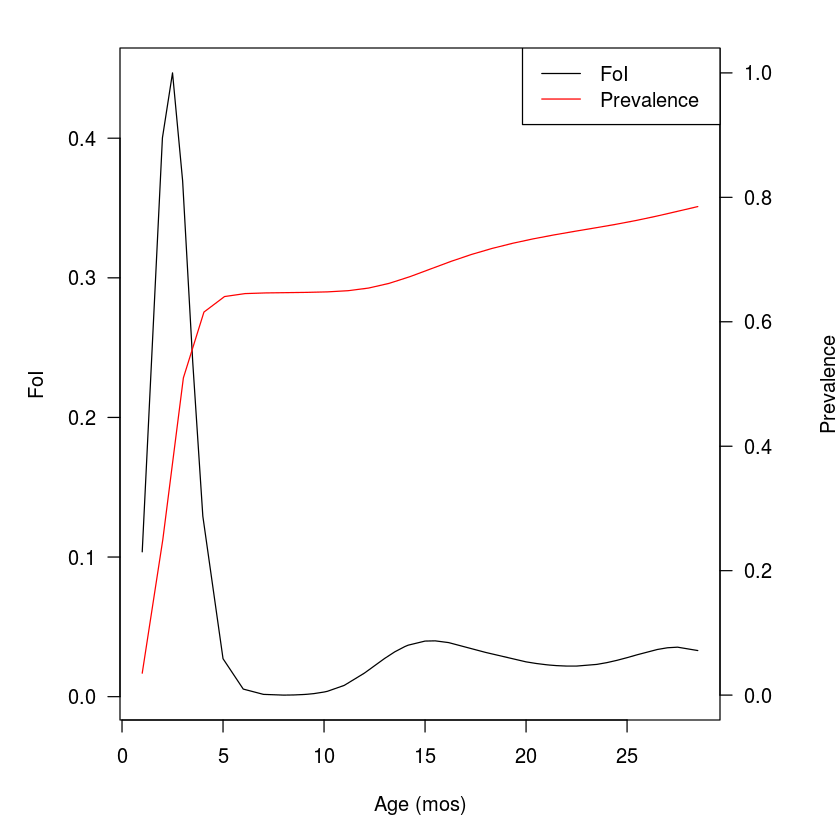

In [15]:
options(warn=-1)
par(mar = c(5, 5, 2, 5)) #Room for two axes
#Overwrite dummy-objects coefficients with MLEs
dl$coefficients = dspline$par 
#Age-prevalce plot
plot(tmpfn(rabbit$a,dl) ~ rabbit$a, type = "l", ylab = "FoI", 
     xlab = "Age (mos)", las = 1)
#Overlay FoI
par(new = TRUE)
p = rep(0, 28)
for (i in 1:28) {
     p[i] = 1 - exp(-integrate(tmpfn, 0, i, 
          dl = dl)$value)
}
plot(p ~ c(1:28), ylim = c(0,1), type = "l", col = "red", 
     axes = FALSE, xlab = NA, ylab = NA)
axis(side = 4, las = 1)
mtext(side = 4, line = 4, "Prevalence")
legend("topright", legend = c("FoI", "Prevalence"),
     lty = c(1,1), col = c("black", "red"))
options(warn=0)

Both the piecewise and spline model show strong evidence of age-specificity in the FoI with a peak in transmission somewhere between 1 and 5 months of age, suggesting that circulation is mainly among the young and among litter-mates . We revisit on this case study in section \[sec:c13bb\].

### Rubella

Rubella is a relatively mild, vaccine-preventable infection except that infection during pregnancy leads to stillbirths or [](https://en.wikipedia.org/wiki/Congenital_rubella_syndrome). The main public health objective is therefore to minimize the FoI in women of childbearing age. The issue was made clear because of a surprising surge in CRS cases in Greece in the mid-90s following a low-intensity vaccination campaign .

Age-intensity data is less ideal than seroprevalence data for catalytic analysis, however it is more common and therefore worth considering. studied age-intensity curves for rubella across the provinces of Peru between 1997 and 2009. There were $24,116$ reported cases during the period. The data are -monthly to age 1 and yearly thereafter (fig. \[fig:peru\]). With age-incidence data on immunizing infections, we can use the catalytic framework to estimate the relative age-specific FoI using the cumulative incidence by age (in place of age-seroprevalence or age-prevalence). For the analysis we use the total number of cases as our denominator because the actual number of susceptibles in each age group is not monitored. Hence, the estimate is a *relative* FoI because of the unknown baseline. Using the total cases as a denominator, further leads to sever biases of the FoI at old age classes (because exactly all of the assumed susceptibles in the final age class will be presumed to be infected at the time), so it should only be applied to the younger portion of the data. Its application also assumes a uniform age-distribution, so a correction for the age-pyramid may be necessary for a more refined analysis .

,age,incidence,cumulative,n
2,0.01095890,1,56,24116
3,0.01369863,1,57,24116
4,0.01643836,1,58,24116
5,0.01917808,2,60,24116
6,0.03561644,1,61,24116
7,0.03835616,2,63,24116


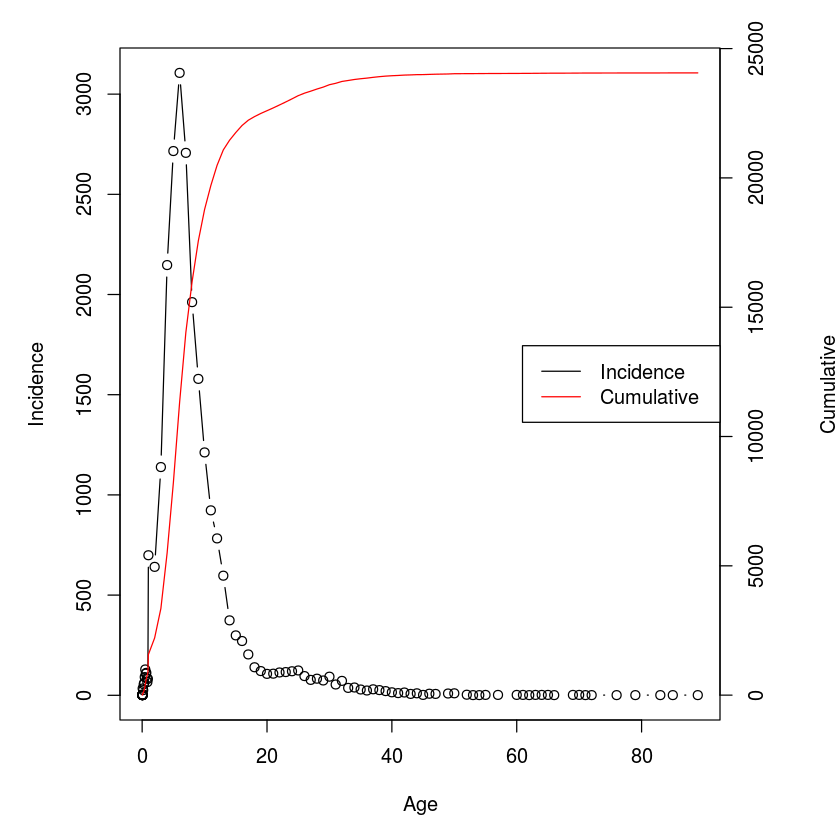

In [16]:
data(peru)
head(peru)
#Calculate cumulative incidence
peru$cumulative=cumsum(peru$incidence)
#Define denominator
peru$n=sum(peru$incidence)
par(mar = c(5,5,2,5)) #Make room for two axes and plot
#Plot incidence with cumulative overlaid
plot(peru$incidence~peru$age, type="b", xlab="Age", 
     ylab="Incidence")
par(new=T)
plot(peru$cumulative~peru$age, type="l", col="red", 
     axes=FALSE, xlab=NA, ylab=NA)
axis(side = 4)
mtext(side = 4, line = 4, "Cumulative")
legend("right", legend=c("Incidence", "Cumulative"),
     lty=c(1,1), col=c("black", "red"))

We first apply the piecewise model assuming a separate FoI for each year up to age 20 and 10 year classes there after. Convergence of the piecewise model with this many segments is very slow so the actual figure (Fig. \[fig:peru2\]) was produce by doing repeat calls to `optim` using different optimization methods (`Nelder-Mead`, `BFGS` and `SANN`), feeding the estimates from each call as starting values for the next. However, the basic analysis is:

  Nelder-Mead direct search function minimizer
function value for initial parameters = 30792.290816
  Scaled convergence tolerance is 0.000458841
Stepsize computed as 0.230259
BUILD             27 32644.012507 27891.708805
EXTENSION         29 30792.290816 26148.012817
LO-REDUCTION      31 30785.524198 26148.012817
LO-REDUCTION      33 30762.120773 26148.012817
LO-REDUCTION      35 30693.446532 26148.012817
LO-REDUCTION      37 30445.317869 26148.012817
LO-REDUCTION      39 30244.073674 26148.012817
LO-REDUCTION      41 30183.815776 26148.012817
LO-REDUCTION      43 30114.622720 26148.012817
LO-REDUCTION      45 30035.359103 26148.012817
LO-REDUCTION      47 29946.057015 26148.012817
LO-REDUCTION      49 29846.604916 26148.012817
LO-REDUCTION      51 29757.054415 26148.012817
LO-REDUCTION      53 29735.263764 26148.012817
LO-REDUCTION      55 29663.961312 26148.012817
LO-REDUCTION      57 29611.449145 26148.012817
LO-REDUCTION      59 29479.559477 26148.012817
LO-REDUCTION      61 2943

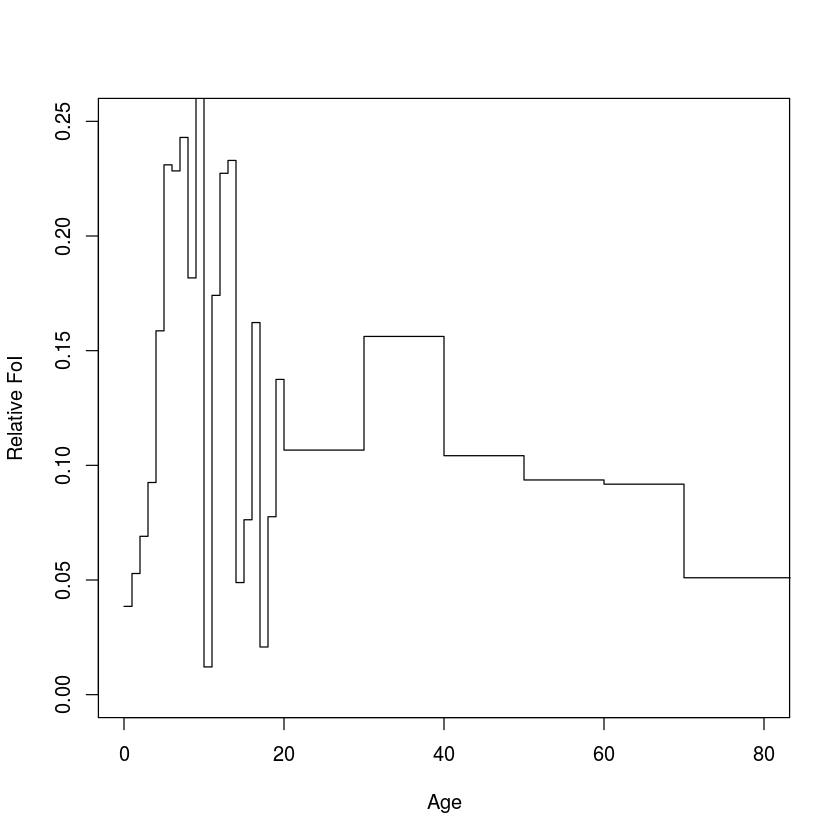

In [17]:
#Upper age cut-offs
up = c(1:20, 30, 40, 50, 60, 70,100)
para = rep(.1, length(up)) #Inital values
#Minimize log-likelihood
est2 = optim(par = log(para),fn = llik.pc, age = peru$age, 
     num = peru$cumulative, denom = peru$n, up = up, 
     method = "Nelder-Mead", control =
     list(trace = 2, maxit = 2000))
#Step plot
x = c(0, up)
y = exp(c(est2$par, est2$par[26]))
plot(x, y, ylab = "Relative FoI", xlab = "Age", type = "s", 
     ylim = c(0, 0.25), xlim = c(0, 80))

We see a clear peak in FoI in the 8-10 age-group. The pattern makes sense given the biology of rubella and the assortative mixing commonly seen in the human host with most contacts being among same-aged individuals (see section \[sec:waifw\]). Peru has a life-expectancy of around 75 years, and the $R_0$ of rubella is typically quoted in the 4-10 range, so according to $\bar{a} \simeq L /(R_0 -1)$ the peak in circulation is predicted to be in an interval around 10 yrs of age.

We can do a more refined scenario-analyses regarding consequences of vaccination using the spline model. We focus on the 0-45 year age-range as this spans the pre- to post- child-bearing age:

In [18]:
data3 = peru[peru$age < 45, ]
df = 5
para = rep(0.1, df + 1)

We use a log-transformation to constrain the FoI to be positive, create the ‘dummy’ `lm`-object, and define the function to evaluate the negative log-likelihood of the FoI curve given the data:

In [19]:
#Prediction function
tmpfn=function(x,dl){
    x=predict(dl, newdata=data.frame(age=x))
exp(x)}
#Dummy lm-object
dl=lm(cumulative~bs(age,df), data=data3)
#Log-likelihood function
tmpfn2=function(par,data, df){
    dl=lm(cumulative~bs(age,df), data=data)
    dl$coefficients=par
    ll=0
    for(a in 1:length(data$age)){
      p=((1-exp(-integrate(tmpfn,0,data$age[a],
         dl=dl)$value)))
      ll=ll+dbinom(data$cumulative[a],data$n[a],p,log=T)
    }
 return(-ll)
 }

Getting a good fit is, again, computationally expensive, but reveals and interesting two-peaked force-of-infection. A dominant peak just under 10 years and a subdominant peak around 35. A plausible scenario is that most people get infected in school but the fraction that escapes this dominant mode of infection are most likely to contract the virus from their children when they reach school age.

  Nelder-Mead direct search function minimizer
function value for initial parameters = 1141035.737231
  Scaled convergence tolerance is 0.0170028
Stepsize computed as 0.230259
BUILD              7 1141035.737231 970950.627465
LO-REDUCTION       9 1137877.634033 970950.627465
LO-REDUCTION      11 1121934.640856 970950.627465
EXTENSION         13 1103727.484754 894493.206451
LO-REDUCTION      15 1094400.861158 894493.206451
EXTENSION         17 1079917.487811 761540.193954
LO-REDUCTION      19 1029493.054676 761540.193954
EXTENSION         21 996693.178557 619430.190272
LO-REDUCTION      23 970950.627465 619430.190272
EXTENSION         25 918394.487677 408688.548477
LO-REDUCTION      27 894493.206451 408688.548477
EXTENSION         29 783649.934481 182510.957601
LO-REDUCTION      31 761540.193954 182510.957601
EXTENSION         33 658497.237544 47258.246308
LO-REDUCTION      35 619430.190272 47258.246308
REFLECTION        37 468878.161804 31095.755010
LO-REDUCTION      39 408688.548477 3

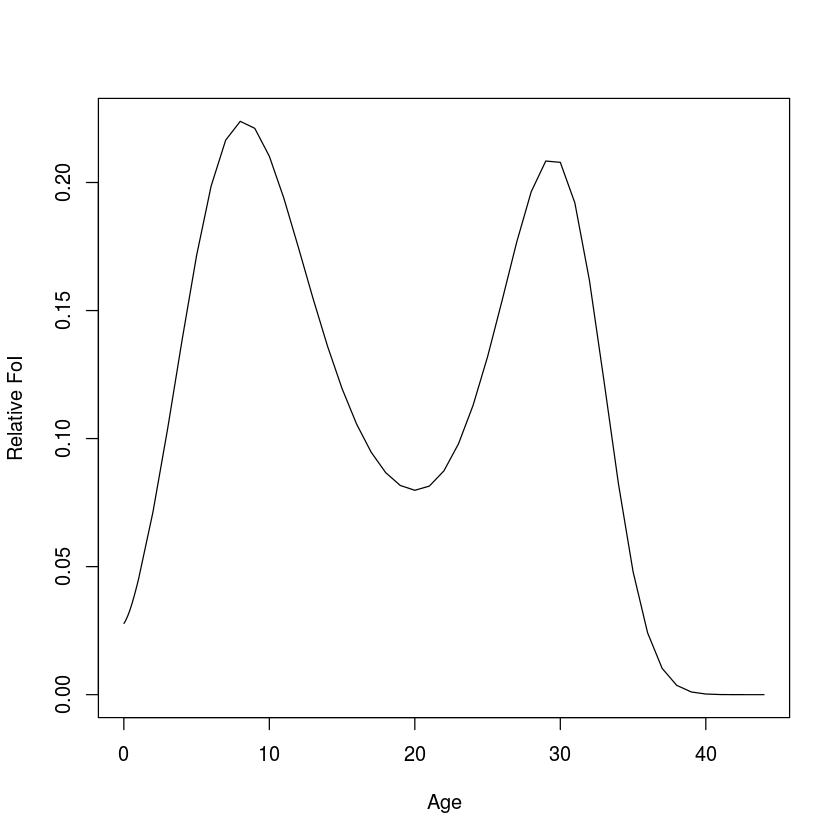

In [20]:
#Fit model
options(warn=-1)
dspline.a45.df5=optim(par=log(para),fn=tmpfn2,
     data=data3, df=df, method="Nelder-Mead", 
     control=list(trace=4, maxit=5000))
#Overwrite dummy-objects coefficients with MLEs
dl$coefficients=dspline.a45.df5$par
plot(exp(predict(dl))~data3$age, xlab="Age", 
     ylab="Relative FoI", type="l")
options(warn=0)

The fraction of cases that is predicted to occur in the child-bearing age-bracket (say, 15-40 years of age) is the joint probability of not being infected by age 15 and the probability of being infected in the 15-40 age range. $$exp(-\int_0^{15} \phi (a) \, da) (1-exp(-\int_{15}^{40} \phi (a) \, da))$$ We can predict this fraction from the spline model.

In [21]:
(exp(-integrate(tmpfn,0,15,dl=dl)$value))*(1-
     exp(-integrate(tmpfn,15,40,dl=dl)$value))

[1] 0.08968591

Thus, with the current pattern of circulation just over $9\%$ of the cases are predicted to occur in the at-risk age group. Let us ask how this fraction will change with a flat $50\%$ reduction in FoI.

In [22]:
redn=0.5
(exp(-redn*integrate(tmpfn,0,15,dl=
     dl)$value))*(1-exp(-redn*integrate(tmpfn,
     15,40,dl=dl)$value))

[1] 0.2266918

### WAIFW

Age-structured FoI’s result from non-assortative mixing among different age-groups. The Who-Acquires-Infection-From-Whom (WAIFW) matrix is used to describe the patterns of non-homogenous mixing among different age-groups . conducted a diary-based social study to map age-stratified contact rates for various countries in Europe as part of the POLYMOD project. The contact rates by `contactor` and `contactee` are provided in the `mossong`-data set. We can visualize the diary data using an image plot with contours superimposed.

contactor,contactee,contact.rate
1,1,120.37234
2,1,33.45833
3,1,23.13380
4,1,24.33333
5,1,29.00662
6,1,14.50331


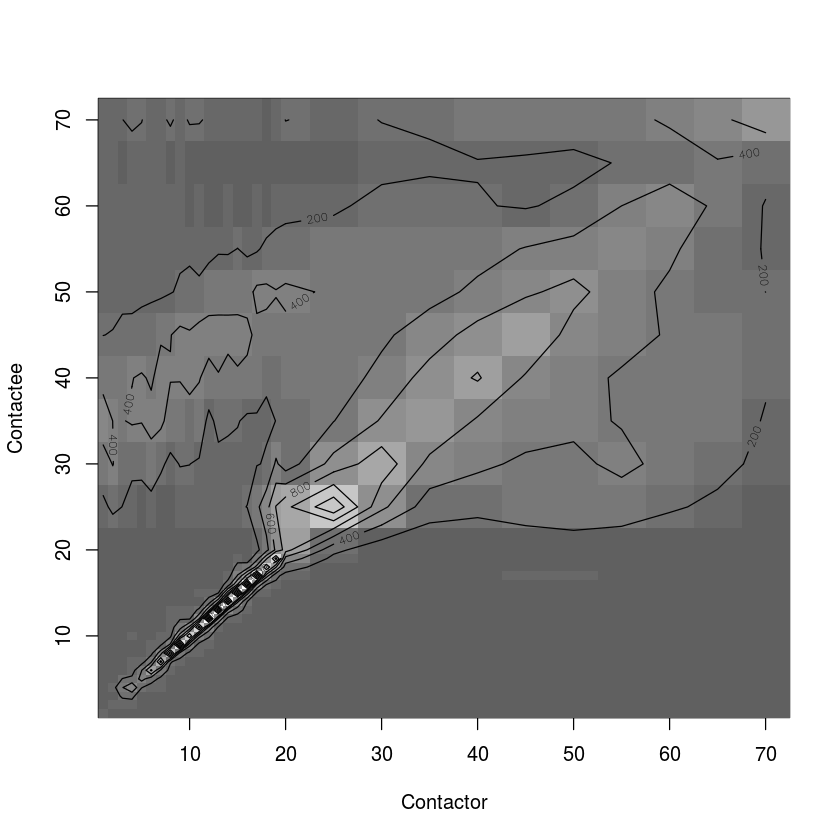

In [23]:
data(mossong)
head(mossong)
x=y=mossong$contactor[1:30]
z=matrix(mossong$contact.rate, ncol=30, nrow=30)
image(x=x, y=y, z=z, xlab="Contactor", 
     ylab="Contactee", col=gray((12:32)/32))
contour(x=x, y=y, z=z, add=TRUE)

The reported contact rates are not symmetrical – which a WAIFW matrix will be – because of age-specific biases in diary entry rates as well as the age-profile of the contactors *versus* contactees. Before we ‘symmetrize’ the matrix we, look at the reported marginal contact rate for each age group . Most contacts are among same-aged individuals and school-age children have the greatest number of contacts. We do, however, also see off-diagonal ridges resulting from for example parent-offspring or teacher-pupil interactions.

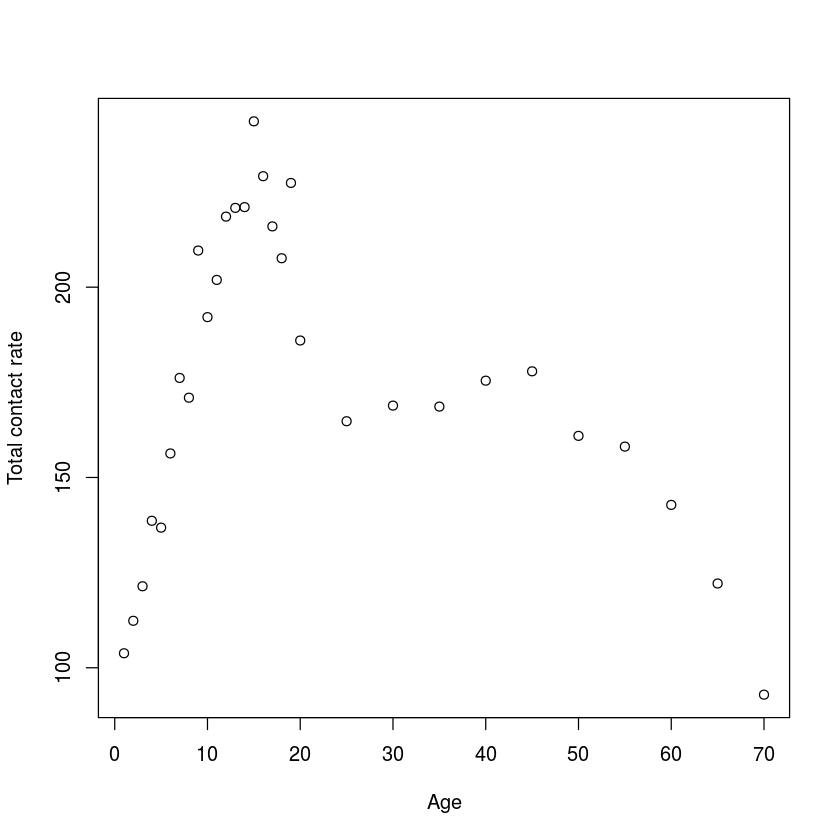

In [24]:
plot(apply(z,1,mean)~x, ylab="Total contact rate",
     xlab="Age")

The symmetrized contact rate matrix is an estimate of the ’WAIFW’-matrix.

Advanced: RAS model
-------------------

 discussed the importance of age-structured mixing when modeling infectious disease dynamics. extended this model to the ‘realistic age-structured (RAS) model’ which in its full elaboration is an age-structured compartmental model with discrete aging of each birth cohort (at the beginning of each school year) and seasonality in transmission. Seasonality is the topic of chapter 4. We can incorporate the POLYMOD contact matrix in a simpler age-structured model. We will make the simplifying assumptions that individuals age exponentially with rates set such that they will on average spend the right amount in each age-bracket. This allows us to formulate the model using chains of ordinary differential equations. The upper-age cut-offs and age-progression rates for the $n=30$ age-categories are `x` and

In [25]:
a = c(1/diff(x), 0)

We can in principle use the raw symmetrized WAIFW matrix in our model, but we will use a thin-plate spline smoothed matrix using the `Tps`-function in the `fields`-package. The smoothing protocol also allow interpolation to use different age-brackets for the model than used in the contact survey whenever necessary.

Loading required package: fields
Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.2-1 (2018-12-20) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


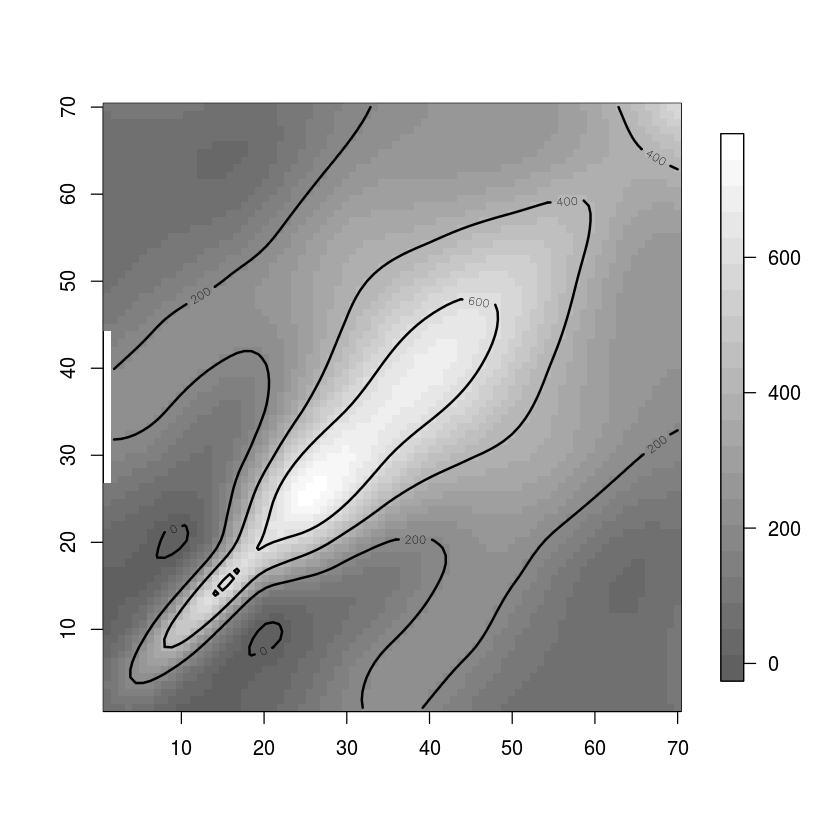

In [26]:
require("fields")
n = length(x)
z2 = (z + t(z))/2
z3 = as.vector(z2)
xy = data.frame(x = rep(x[1:n], n), y = rep(y[1:n], each = n))
polysmooth = Tps(xy, z3, df = 100)
surface(polysmooth, xlab = "", ylab = "", 
     col=gray((12:32)/32))

For our age-structured SIR model we first normalize the WAIFW matrix:

In [27]:
W = matrix(polysmooth$fitted.values[, 
     1]/mean(polysmooth$fitted.values), nrow = n)

The age-specific force-of infection is $\vec{\phi} = \beta \vec{W} \vec{I} / N$. The age-structured SIR model is thus (in log-coordinates)[6]:

In [28]:
siragemod = function(t, logx,  params){
     n=length(params$a)
     x = exp(logx)
     S = x[1:n]
     I = x[(n+1):(2*n)]
     R = x[(2*n+1):(3*n)]
     with(as.list(params), {
          phi = (beta*W%*%I)/N
          dS = c(mu,rep(0,n-1)) - (phi+a)*S + 
              c(0,a[1:n-1]*S[1:n-1])*(1-p) - mu*S
          dI = phi*S + c(0,a[1:n-1]*I[1:n-1]) - 
             (gamma+a)*I - mu*I
          dR =  c(0,a[1:n-1]*S[1:n-1])*p + 
             c(0,a[1:n-1]*R[1:n-1]) + gamma*I - 
             a*R - mu*R
     res = c(dS/S, dI/I, dR/R)
     list((res))
     })
}

where `S`, `I` and `R` are vectors of length $n$, $\phi$ is the age-specific force of infection predicted by the WAIFW matrix and $p$ is a vector of length $n$ that allows for age-specific vaccination rates (we will assume no vaccination). The $a$-vector sets appropriate aging rates if age-groups varies in duration. We use the following parameters and initial conditions:

In [29]:
p.pre = rep(0,n)
pars.pre = list(N = 1, gamma = 365/14, mu = 0.02, sigma = 0.2, 
     beta = 100, W = W,p = p.pre, a = a)
ystart = log(c(S = rep(0.099/n,n), I = rep(0.001/n,n), 
     R = rep(0.9/n,n)))

and integrate to plot the age-specific I-dynamics and equilibrium age-specific prevalence for the polymod matrix.

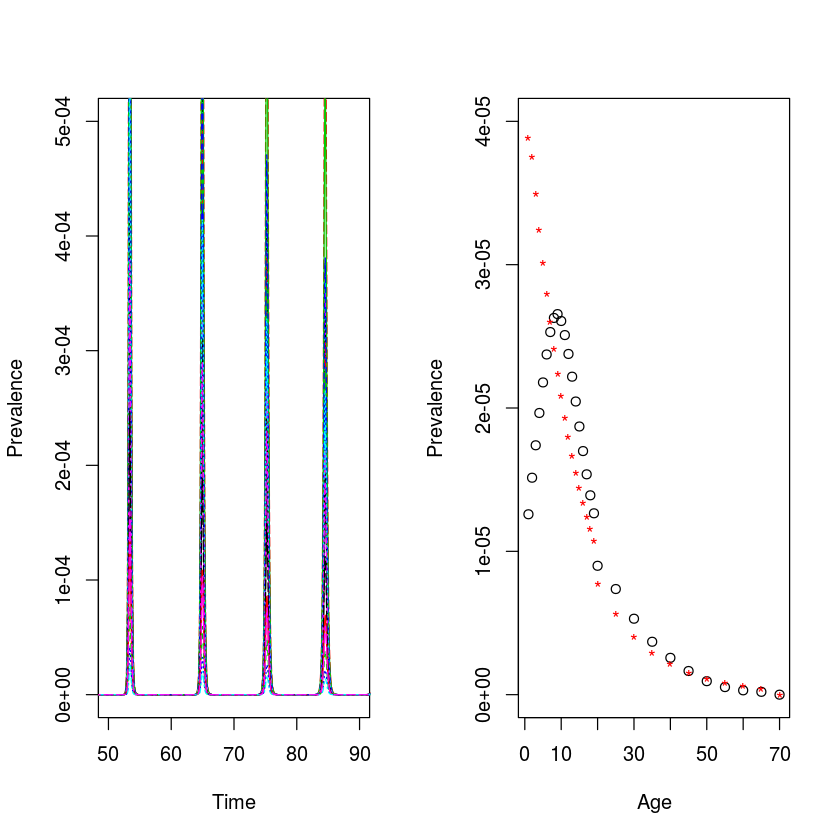

In [30]:
times = seq(0, 500, by = 14/365)
#Polymod mixing
out=as.data.frame(ode(ystart, times=times, 
     func = siragemod, parms = pars.pre))
par(mfrow = c(1,2)) #Room for side-by-side plots
#Time series
matplot(times, exp(out[,32:61]), type = "l", xlab = "Time", 
    ylab = "Prevalence", xlim = c(50, 90), ylim = c(0, 0.0005))
#Final age-prevalence curve
plot(x, t(exp(out[13036, 32:61])*a), ylab = "Prevalence", 
    xlab = "Age", ylim = c(0, 4E-5))
#Homogenous mixing:
pars.pre$W = matrix(1, ncol = 30, nrow = 30)
out2=as.data.frame(ode(ystart, times=times, 
    func=siragemod, parms=pars.pre))
points(x, t(exp(out2[13036,32:61])*a), col=2, pch="*")